\begin{center} 
Chun-Yuan (Scott) Chiu 
\end{center}
\begin{center} 
chunyuac@andrew.cmu.edu 
\end{center}

# 1. {-}

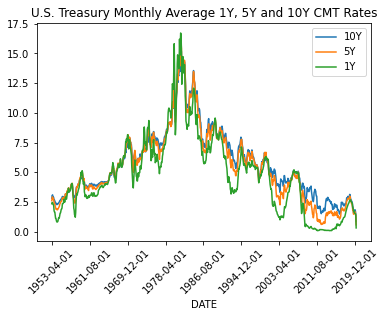

In [2]:
import pandas as pd

rates = pd.read_csv('fredgraph.csv', index_col=0)
rates.columns = [col.replace('GS', '') + 'Y' for col in rates.columns]
rates.plot(rot=45, title='U.S. Treasury Monthly Average 1Y, 5Y and 10Y CMT Rates')
pass

In [3]:
import statsmodels.tsa.api as smt
from pandas import DataFrame

smt.stattools.adfuller(rates['1Y'])[4]

{'1%': -3.4387291412780177,
 '5%': -2.8652383048736056,
 '10%': -2.568739332674375}

In [4]:
DataFrame({col: smt.stattools.adfuller(rates[col])[:2] for col in rates.columns}, index=['Test Statistic', 'p-value'])

,10Y,5Y,1Y
Test Statistic,-0.866806,-1.060174,-1.774502
p-value,0.798707,0.730690,0.393192


In [6]:
ratesdiff = rates.diff().dropna()

DataFrame({col: smt.stattools.adfuller(ratesdiff[col])[:2] for col in rates.columns}, index=['Test Statistic', 'p-value'])

,10Y,5Y,1Y
Test Statistic,-6.889457e+00,-6.814311e+00,-6.783201e+00
p-value,1.367493e-09,2.077893e-09,2.469366e-09


In [20]:
from arch.unitroot.cointegration import phillips_ouliaris, engle_granger
from itertools import combinations

for tnr1, tnr2 in combinations(rates.columns, 2):
    print(f'Tenor Pair: {tnr1, tnr2}')
    print('-------------------------')
    print(phillips_ouliaris(ratesdiff[tnr1], ratesdiff[tnr2]))
    print()
    print(engle_granger(ratesdiff[tnr1], ratesdiff[tnr2], trend='n'))
    print()

Tenor Pair: ('10Y', '5Y')
-------------------------
Phillips-Ouliaris zt Cointegration Test
Statistic: -25.681091711295867
P-value: 0.0
Null: No Cointegration, Alternative: Cointegration
Kernel: Bartlett
Bandwidth: 11.541
Trend: c
Distribution Order: 3

Engle-Granger Cointegration Test
Statistic: -22.512509228230552
P-value: 0.0
Null: No Cointegration, Alternative: Cointegration
ADF Lag length: 1
Trend: c
Estimated Root ρ (γ+1): -0.05707291974346895
Distribution Order: 1

Tenor Pair: ('10Y', '1Y')
-------------------------
Phillips-Ouliaris zt Cointegration Test
Statistic: -22.759071722778206
P-value: 0.0
Null: No Cointegration, Alternative: Cointegration
Kernel: Bartlett
Bandwidth: 7.1030
Trend: c
Distribution Order: 3

Engle-Granger Cointegration Test
Statistic: -14.260846670972638
P-value: 7.974381506338384e-29
Null: No Cointegration, Alternative: Cointegration
ADF Lag length: 3
Trend: c
Estimated Root ρ (γ+1): 0.1296649573334162
Distribution Order: 1

Tenor Pair: ('5Y', '1Y')
-----

In [55]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from itertools import combinations

for tnr1, tnr2 in combinations(rates.columns, 2):
    cj = coint_johansen(ratesdiff[[tnr1, tnr2]], det_order=0, k_ar_diff=0)
    print(f'Tenor Pair: {tnr1, tnr2}')
    print('-------------------------')
    print('Trace Statistics (for Rank > 0, Rank > 1): ', cj.trace_stat)
    print('Critical Values: ')
    print(DataFrame(cj.trace_stat_crit_vals, columns=['90%', '95%', '99%'], index=['Rank > 0', 'Rank > 1']))
    print()
    print('Maximum Eigenvalue Statistics: ', cj.max_eig_stat)
    print('Critical Values: ')
    print(DataFrame(cj.max_eig_stat_crit_vals, columns=['90%', '95%', '99%'], index=['Rank > 0', 'Rank > 1']))
    print()

Tenor Pair: ('10Y', '5Y')
-------------------------
Trace Statistics (for Rank > 0, Rank > 1):  [824.55898029 325.61219726]
Critical Values: 
              90%      95%      99%
Rank > 0  13.4294  15.4943  19.9349
Rank > 1   2.7055   3.8415   6.6349

Maximum Eigenvalue Statistics:  [498.94678303 325.61219726]
Critical Values: 
              90%      95%      99%
Rank > 0  12.2971  14.2639  18.5200
Rank > 1   2.7055   3.8415   6.6349

Tenor Pair: ('10Y', '1Y')
-------------------------
Trace Statistics (for Rank > 0, Rank > 1):  [739.07285782 319.69487487]
Critical Values: 
              90%      95%      99%
Rank > 0  13.4294  15.4943  19.9349
Rank > 1   2.7055   3.8415   6.6349

Maximum Eigenvalue Statistics:  [419.37798295 319.69487487]
Critical Values: 
              90%      95%      99%
Rank > 0  12.2971  14.2639  18.5200
Rank > 1   2.7055   3.8415   6.6349

Tenor Pair: ('5Y', '1Y')
-------------------------
Trace Statistics (for Rank > 0, Rank > 1):  [745.80210501 312.01776498]
C

# 2. {-}

Let $\mathbf X_t, \mathbf\epsilon_t$ be the $p-$dimensional vectors defined as follows:
\begin{align*}
\mathbf X_t &= (Y_t-\mu, Y_{t-1}-\mu\ldots, Y_{t-p+1}-\mu)^T, \\
\mathbf\epsilon_t &= (\epsilon_t, 0, \ldots, 0)^T. 
\end{align*}
Let 
\begin{align*}
\mathbf F = \begin{pmatrix}
\phi_1 & \phi_2 & \phi_3 & \cdots & \phi_{p-1} & \phi_{p} \\
1 & 0 & 0 & \cdots & 0 & 0\\
0 & 1 & 0 & \cdots & 0 & 0\\
0 & 0 & 1 & \ddots & 0 & 0\\
\vdots & \vdots & \vdots & \ddots & \ddots & \vdots\\
0 & 0 & 0 & \cdots & 1 & 0
\end{pmatrix}_{p\times p}.
\end{align*}
Then the state space form of the AR(p) process 
\begin{align*}
Y_t - \mu = \phi_1(Y_{t-1}-\mu) + \cdots + \phi_p(Y_{t-p}-\mu) + \epsilon_t
\end{align*}
is 
\begin{align*}
\mathbf X_t &= \mathbf F\mathbf X_{t-1} + \mathbf\epsilon_t, \\
Y_t-\mu &=  (1, 0, \ldots, 0)\mathbf X_t.
\end{align*}

# 3. {-}

\begin{align*}
Y_t - Y_{t-1} = M_t - M_{t-1} + W_t - W_{t-1} = V_{t-1} + W_t - W_{t-1}. 
\end{align*}

